## Problem 7.20

To develop a functioning SEM solver, we need a number of ingredients that have been developed in previous problems. In the cell below, we copy a number of functions that we will use: 

| Function         | Developed in Problem | Functionality                                                                                                                                      |
|:---------------- |:-------------------- |:-------------------------------------------------------------------------------------------------------------------------------------------------- |
| ```gll```        | Problem 7.17         | This finds the GLL points given for the degree $n$ Lagrange polynomials.                                                                           |
| ```weights```    | Problem 7.18         | Developed in Problem 7.18 - this finds weights at GLL points and also returns the gll points (so we don't have to explicitly call ```gll``` again! |
| ```dlagrange1``` | Problem 7.19         | Finds first derivative of lagrange polynomials at GLL points.                                                                                      |


In [1]:
# Hidden cell with functions: 
import scipy.special as ss 
import numpy as np 
import matplotlib.pyplot as plt 
from copy import copy
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def gll(n, Nsegs=100): 
    # This function is the solution to 7.17. 
    # It is not the most efficient way to compute GLL points,
    # but it works!
    nroots  = n + 1              # Number of roots
    roots   = np.zeros(nroots)   # Array to hold all the roots
    leg_n   = ss.legendre(n)    # P_n  
    leg_n_1 = ss.legendre(n-1)  # P_{n-1}

    def compute_functional(xi, n, lnm1, ln):
        return n * (lnm1(xi) - xi * ln(xi))
    
    # End points 
    roots[0]   = -1
    roots[-1]  =  1
    nrts_found =  2

    if nroots > 3:
        xi_end = 0.99999
        if n%2==0:
            xi_start = 0.00001
            nrts_found += 1
        else:
            xi_start = 0.0
        segments = np.linspace(xi_start, xi_end, Nsegs)
        fseg = compute_functional(segments, n, leg_n_1, leg_n)
        # Index in the 'roots' array to store the root
        idx = int(nroots / 2) + nroots%2 
        # Loop through each segment and test if root lies within
        for iseg in range(Nsegs-1):
            if fseg[iseg] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg+1] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg] * fseg[iseg+1] < 0:
                # There is a change in sign between the two values:
                # Start with the current edge xi positions of the 'segment'
                a = segments[iseg]
                b = segments[iseg+1]
                error = 999
                while np.abs(error) > 1e-9:
                    grad =  compute_functional(b, n, leg_n_1, leg_n) \
                          - compute_functional(a, n, leg_n_1, leg_n)
                    this_root = a + (b-a)/2
                    error    =  compute_functional(this_root, n, leg_n_1, leg_n)
                    if error !=0:
                        if grad*error > 0:
                            b = copy(this_root)
                        else:
                            a = copy(this_root)
                roots[idx] = this_root
                idx += 1
                nrts_found+=2
                
        for irt in range(1, int(n/2) + n%2):
            i1 = int(nroots/2) -irt
            i2 = int(nroots/2) +irt  - n%2 
            roots[i1] = -roots[i2]
        return roots 
    

def lagrange(N, a, x, GLL):
    # Computes a'th Lagrange polynomial of degree N at points x
    # using control points specified in GLL array
    poly = 1
    for j in range(0, N+1):
        if j != a:
            poly = poly * ((x - GLL[j]) / (GLL[a] - GLL[j]))
    return poly


def weights(n): 
    # n is degree of lagrange 
    # returns the n+1 gll points and 
    # corresponding weights
    
    # Compute the n+1 GLL points
    gllpts = gll(n)

    # Define the domain interval [-1, +1] on 1000 points:
    x = np.linspace(-1, 1, 1000)

    weights = []
    # Loop over the n+1 polynomials to compute the weights
    for alpha in range(n+1): 
        # Integrand is simply the alpha'th lagrange polynomial of degree n
        integrand = lagrange(n, alpha, x, gllpts)

        # Trapezoid rule to integrate
        weights.append(np.trapz(y=integrand, x=x))
    return gllpts, np.array(weights)


def dlagrange1(n): 
    # Computing deriv of lagrange specifically at GLL points: 
    # Using method in Canuto et al 2006
    # for degree n lagrange polynomials
    # RETURNS: 
    # 2D numpy array: 
    # [i,j] represents the derivative of the i'th lagrange polynomial 
    # at the xi position of the j'th GLL point
    # e.g. [i,j] is l^n'_i(xi_j)
    gllpts = gll(n)
    
    derivatives = []
    for i in range(n+1):
        # Loop over GLL points 
        derivs = []

        leg_n = ss.legendre(n)
        for j in range(n+1):
            if i == 0 and j == 0:
                derivs.append(-(n+1)*n/4)
            elif i == n and j == n: 
                derivs.append((n+1)*n/4)
            elif i != j:  
                derivs.append(leg_n(gllpts[j]) / ( leg_n(gllpts[i]) * (gllpts[j]-gllpts[i]) ))
            else: 
                derivs.append(0) 
                
        derivatives.append(derivs)
    return np.array(derivatives)

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Setting up the domain 
First things first need to set up the domain. In this case we are using 12 elements. Lets use 7 GLL points in each element. For the timestepping, we will use $\eta = 0.5$ in the Generalised Trapezoidal Time Scheme (Section 7.3.3), equivalent to a centered difference method in time. 

In [2]:
L      = 1            # Domain size
n      = 6            # Lagrange degree
ngll   = n + 1        # number of gll per element
nelmts = 12           # Number of elements
nbound = nelmts + 1   # Number of element boundaries

# Timestepping
eta    = 0.5          # Predictor corrector eta 
dt     = 0.00001      # Timestep 
nsteps = 20000        # Number of timesteps


# Physical parameter: 
# diffusivity, alpha = 1 everywhere
alpha = np.zeros((ngll, nelmts)) + 1 

The spatial domain is defined between $x \in [0, 1]$. The elements will be evenly spaced (though they don't have to be!). First, let us find where the element boundaries are: 

In [3]:
# Global coordinates of element boundaries
elembnds = np.linspace(0, L, nbound)
elemsize = elembnds[1:] - elembnds[:-1]

### Local to global mapping
Next, we can get the location of the GLL points in the natural domain, $\xi \in [-1, 1]$. Given the number of GLL points in each element, we can determine the global number of GLL points (since elements share GLL points on their boundaries. 

Next, we wish to determine the coordinates of each global GLL point in the spatial domain. As we loop through each element to calculate this, we also compute the array called ```ibool```. This array holds the mapping of node ID's between each element and the global ID of the nodes. 

Let us take the second and third elements in our domain, for example. Both elements have 7 GLL nodes. Within each element, these nodes simply have local IDs of $a = 1,\dots7$ (or $a = 0,\dots6$ in python indexing). 

However these nodes have global IDs of $A = 7\dots 19$. Note that the node with global ID $A = 13$ is the last node of element 2, and also the first node of element 3. See Fig 7.9 for an example with 5 GLL nodes in each element.

The ibool array stores the global IDs for each local node in each element, that is: 
```
globalID = ibool(local_id, element_id)
```

Below, we plot the domain setup for clarity, with vertical lines representing element boundaries

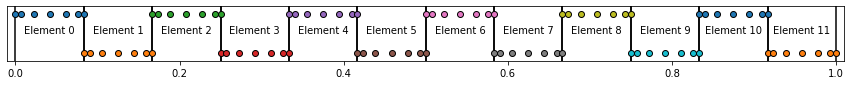

In [4]:
# Get GLL and weights: 
xigll, wgll = weights(n)


# Create an array of the GLOBAL node coordinates: 
nglob = nelmts*(ngll-1) + 1


# Array of global node x coordinates
# and ibool (lobal --> global mappping)
xcoord = np.zeros(nglob)
ibool = np.zeros((ngll, nelmts)).astype(int)
for ielem in range(nelmts): 
    xcoord[n*ielem : n*ielem+ngll] = elembnds[ielem] + elemsize[ielem]*(xigll+1)/2
    ibool[:, ielem] = np.arange(n*ielem, n*ielem+ngll)
    
    
    
# Plot domain setup for reference
fig, ax = plt.subplots(figsize=(15,1))
for ielem in range(nelmts): 
    # Add element boindaries
    ax.axvline(xcoord[ibool[0, ielem]], color='k', zorder=0)
    ax.axvline(xcoord[ibool[-1, ielem]], color='k', zorder=0)
    # Plot GLL points 
    ax.scatter(xcoord[n*ielem : n*ielem+ngll], 
               (-1)**ielem + np.zeros(len(xcoord[n * ielem: n * ielem + ngll])),
               marker='o', edgecolor='k' )
    # Add some text for each element
    ax.text(x=xcoord[n*ielem+ ngll//2] , y=0, s=f'Element {ielem}',horizontalalignment='center')

ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-1.4, 1.4])
ax.set_yticks([]);

#### Jacobian of the mapping
Next we need the jacobian. This requires computing $\frac{\mathrm{d}x}{\mathrm{d}\xi}$ at the GLL points. We know that the mapping between the real spatial domain $x \in [0, 1]$ and the natural domain, $\xi \in [-1, 1]$ is defined by 
\begin{equation*}
x(\xi) = \sum_{a=0}^{n} x_a \, \ell^n_a(\xi)
\end{equation*}
then the derivative is 
\begin{equation*}
\frac{\mathrm{d}x}{\mathrm{d}\xi} = \sum_{a=0}^{n} x_a \, \partial_\xi \ell^n_a(\xi)
\end{equation*} 
and so to sample this at a specific GLL point, say $\xi_\gamma$, we have 
\begin{equation*}
J_\gamma = \frac{\mathrm{d}x}{\mathrm{d}\xi}(\xi_\gamma) = \sum_{a=0}^{n} x_a \, \partial_\xi \ell^n_a(\xi_\gamma)
\end{equation*}

Note that for this very simple mapping the jacobian is analytical and is constant across the domain. If the elements were not evenly spaced, it would not be constant. For each element we will calculate this Jacobian using the general method described above: 

In [5]:
# Derivative of lagrange polynomial
# from Problem 7.17
# dlag1[i,j] is l^n'_i(xi_j)
dlag1 = dlagrange1(n)


# Compute jacobian: 
# jac[i, ielem] is jacobian at 
# gll point i within element ielem
jac = np.zeros((ngll, nelmts))
for ielem in range(nelmts):
    for gamma in range(ngll): 
        # Evaluate sum over a 
        for igll in range(ngll): 
            jac[gamma, ielem] += xcoord[ibool[igll, ielem]] * dlag1[igll, gamma]

### Matrix computation and assembly
#### Mass Matrix

The mass matrix is diagonal, so we will store it as a vector. It must be assembled globally. Lets do this below and look at the structure of it. For a homogeneous medium the matrix will be the same for each element, except at the boundaries

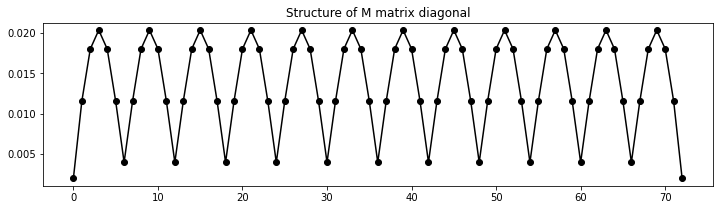

In [9]:
# Mass matrix is diagonal so can be 1 x nglob
M = np.zeros(nglob)

# For each element we can construct 
# the local (diagonal) matrix and assemble: 
for ielem in range(nelmts):
    for igll in range(ngll): 
        # global node ID 
        iglob = ibool[igll, ielem]

        # local mass matrix is scalar
        mass_local = wgll[igll]*jac[igll,ielem] 
        
        # add to global mass matrix
        M[iglob] +=  mass_local
       
    
# Plot the matrix diagonal for reference below
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(np.arange(nglob), M, '-ok')
ax.set_title('Structure of M matrix diagonal');     

#### Stiffness matrix
The stiffness matrix is not diagonal, but does not necessarily need to be assembled. Consider the global system
\begin{equation*}
\mathsf{M}\dot{\mathsf{\theta}} = \mathsf{F} - \mathsf{K}\mathsf{\theta} \quad. 
\end{equation*} We observe that only the matrix-vector product $\mathsf{K}\mathsf{\theta}$ needs to be available globally. Hence, we could compute this vector locally for each element, and then assemble that vector globally. This avoids assembly of the global stiffness matrix. For our case when the degrees of freedom is small, we can afford to assemble the matrix. Below however, we include code that shows how to run the same solver without this global assembly. 

You may find that the method avoiding global assembly is much slower, since we are effectively recomputing the local stiffness matrix at each timestep. There is therefore a tradeoff between performance and storage availability; if you can afford to store the whole K matrix in memory, it might be beneficial! 

Below we see the stiffness matrix is a banded, block diagonal matrix ```ngll``` diagonals that are non-zero

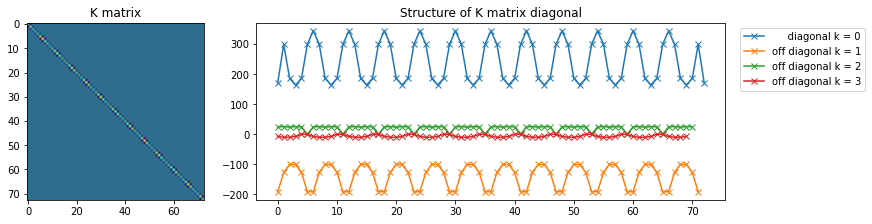

In [7]:
AVOID_GLOBAL_ASSEMBLY = False 


if not AVOID_GLOBAL_ASSEMBLY:
    # Initialise global stiffness matrix 
    K = np.zeros((nglob, nglob))
    
    # Assemble K matrix : using Eqn 7.125
    for ielem in range(nelmts):

        # Loop over elements a,b of the local matrix
        for a in range(ngll): 
            glob_id_row = ibool[a, ielem]

            for b in range(ngll):
                glob_id_col = ibool[b, ielem]

                kab = 0 
                for g in range(ngll): 
                    kab += wgll[g] * alpha[g,ielem] * dlag1[a,g] * \
                           dlag1[b,g] / jac[g, ielem]

                # Now lets add this kab to the global matrix: 
                K[glob_id_row, glob_id_col] += kab


    # Plot K matrix:
    fig    = plt.figure(figsize=(12,3), constrained_layout=True)
    gs     = fig.add_gridspec(3, 10)
    axKmat = fig.add_subplot(gs[:, :3])
    axstrc = fig.add_subplot(gs[:, 3:])

    axKmat.imshow(K)

    for k in range(4):
        if k==0: 
            label = f'     diagonal k = {k}'
        else:  
            label = f'off diagonal k = {k}'
        axstrc.plot(np.arange(nglob-k), np.diag(K, k=k), '-x', label=label)

    axstrc.legend(bbox_to_anchor=(1.02, 1.))
    axstrc.set_title('Structure of K matrix diagonal');   
    axKmat.set_title('K matrix');    

### Boundary coniditions

Next, we need to compute the force vector. There is no internal heating so Eqn 7.127 reduces to 
\begin{equation*}
f_\alpha = \alpha_n \sum_{\beta=0}^n \theta_\beta \ell'^n_{\beta}(\xi_n)\,\partial_x\xi(\xi_n) \: - \alpha_0 \sum_{\beta =0}^n \theta_\beta \ell'^n_{\beta}(\xi_0) \: \partial_x\xi(\xi_0) 
\end{equation*}
where the two terms are contributed by the last and first elements respectively. 

The initial condition sets $\theta(x,0) = 0$ however the boundary condition also necessitates that $\theta(1,\,t) = 1 $. Similar to Problem 7.14, this introduces a discrepency. In computing the force vector, we enforce that $\theta(1,\,t) = 1 $.  


### Solver: 
Finally, we are ready to run our solver! Below, we plot the temperature profile at different timesteps as the system evolves. We observe the system go from its heaviside-like temperature profile to a smooth, linear gradient in temperature with depth. 

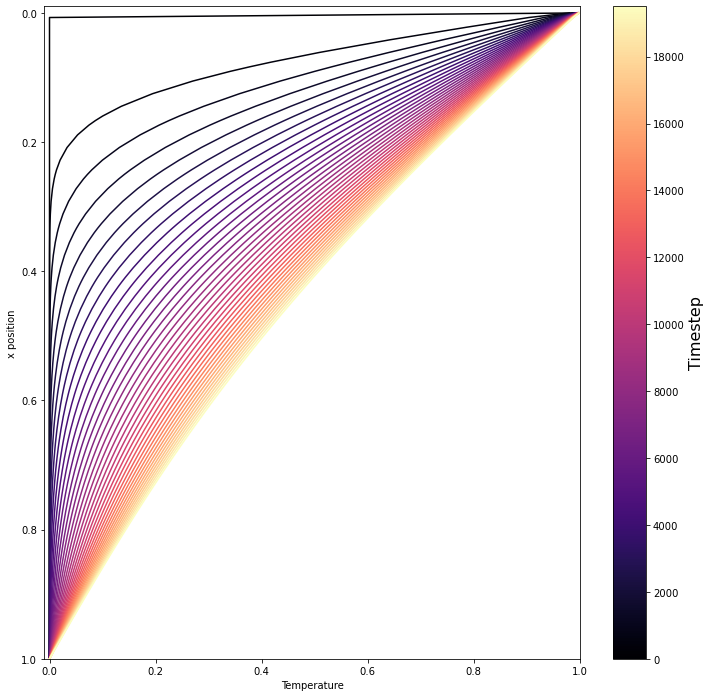

In [8]:
# Initialise the temperature 
# and time-derivative of temperature
# Initial condition is 0 everywhere
theta           = np.zeros(nglob)
dtemperature_dt = np.zeros(nglob)

# The matrix-vector RHS product 
rhs_global = np.zeros(nglob)

# Boundary temperatures we will enforce 
temp0 = 1
tempN = 0


# Setup plotting 
fig, ax = plt.subplots(figsize=(12,12))
plot_every = 500

# Colorbar for plotting through time 
cmap = cm.magma
norm = mcolors.Normalize(vmin=0, 
                         vmax=nsteps//plot_every-1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Timestep', fontsize=16)
cbar.set_ticks(np.arange(0, nsteps//plot_every, 4))
cbar.set_ticklabels(np.arange(0, nsteps, 4*plot_every))


# Step in time 
for istep in range(nsteps):
    
    # ------------ STEP 1: predictor step -----------------------
    theta += (1-eta) * dt * dtemperature_dt
    
    
    # ------------ STEP 2: solver step --------------------------
    if AVOID_GLOBAL_ASSEMBLY: 
        # Avoid global assembly of K:
        rhs_global[:] = 0
        
        # Loop global elements 
        for ispec in range(nelmts): 
            for i in range(ngll): 
                iglob = ibool[i, ispec]

                for j in range(ngll):
                    for k in range(ngll):
                        # Local K matrix:
                        diffusivity = wgll[k] * dlag1[i,k] *         \
                                      dlag1[j,k] / jac[k,ispec]
                            
                        # Assembly global RHS (mat-vec product)
                        rhs_global[iglob] -= diffusivity *           \
                                             theta[ibool[j,ispec]]
    else: 
        # Use globally assembled matrix: 
        rhs_global =  -np.matmul(K, theta)
    
    # Add boundary condition forcing: 
    theta[0]  = temp0
    theta[-1] = tempN
    
    # --- RHS boundary
    bNsum = 0
    for bb in range(ngll): 
        bNsum += theta[ibool[bb,-1]] * dlag1[bb,-1] / jac[-1, -1]
    rhs_global[-1] += alpha[-1,-1]*bNsum
    
    # --- LHS boundary
    b0sum = 0
    for bb in range(ngll): 
        b0sum += theta[ibool[bb,0]] * dlag1[bb,0] / jac[0,0]
    rhs_global[0] += -alpha[0,0]*bNsum
    
    
    # inverse of Mass matrix * RHS 
    dtemperature_dt = rhs_global / M
    

    # ------------ STEP 3: corrector step -----------------------
    theta = theta + (eta * dt * dtemperature_dt)



    # Plot some of the timesteps
    if istep % plot_every ==0:
        ax.plot(theta, xcoord, color=cmap(norm(istep//plot_every)))
  


# Cosmetics for the plot: 
ax.set_xlim([-0.01, 1]);
ax.set_ylim([1, -0.01]);
ax.set_ylabel("x position");
ax.set_xlabel("Temperature");